# Transformer model for book pubish date prediction using roberta-base

In [1]:
#imports

import pandas as pd
import torch
import seaborn as sns
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Read the dataset from our preprocessed json file

In [2]:
df = pd.read_json('../../gutenberg-dataset-v2.json')

#### We only take samples from 1820-1920 because we want to have approx. 100 samples per year and then we split it into train and test subsets

In [3]:
df = df[df['date'] >= 1820]
df = df[df['date'] <= 1920]

earliest_date = df['date'].min()
latest_date = df['date'].max()

samples_list = []
for year in range(earliest_date, latest_date + 1):
    df_year = df[df['date'] == year]
    if len(df_year) > 100:
        samples = df_year.sample(100, random_state=42)
        samples_list.append(samples)
    else:
        samples_list.append(df_year)

df_samples = pd.concat(samples_list)
df_samples['labels'] = df_samples['date'].apply(lambda date: np.interp(date, [earliest_date, latest_date], [-1, 1]))

# Split data into train and test subsets
df_train, df_test = train_test_split(df_samples, test_size=0.2, random_state=42, shuffle=True)
df_train

,title,author,date,text_ratio,text,text_len_characters,weights,labels
212037,"A Five Years' Residence in Buenos Ayres, Durin...",George Thomas Love,1820,0.961988,night they have a custom of illuminating the f...,11613,0.040000,-1.00
13747,The Literary Remains of Samuel Taylor Coleridg...,Samuel Taylor Coleridge,1838,0.963041,become a new cause of its steaming up clouds a...,11610,0.020833,-0.64
80766,Yorksher Puddin' / A Collection of the Most Po...,John Hartley,1839,0.935556,a sob shoo thear it is an aw hooap thall net f...,9302,0.022222,-0.62
98533,"Great Musical Composers: German, French, and I...",George T. Ferris,1887,0.964077,great masters of the last century tried their ...,11664,0.017857,0.34
194397,"Philip Augustus; or, The Brothers in Arms",G. P. R. James,1837,0.958618,scream from the waitingmaid alixe woke them fr...,10889,0.012500,-0.66
...,...,...,...,...,...,...,...,...
188040,The Ceramic Art / A Compendium of The History ...,Jennie J. Young,1878,0.951185,beauty of the coloring of hizen porcelain is i...,11335,0.013889,0.16
212557,Ekkehard: A Tale of the Tenth Century. Vol. 2 ...,Joseph Victor von Scheffel,1872,0.959083,from the wellknown lines at last he seized his...,10857,0.031250,0.04
235750,The Prairie Flower: A Tale of the Indian Border,Gustave Aimard,1874,0.954794,but all is not lost i hope he said let us coll...,10953,0.023256,0.08
18639,State of the Union Addresses,Andrew Jackson,1829,0.983855,executive offices to which it been granted and...,11910,0.027778,-0.82


#### Setup and train the model

In [4]:
# Train and Evaluation data needs to be in a Pandas Dataframe containing at least two columns.
# If the Dataframe has a header, it should contain a 'text' and a 'labels' column.
# If no header is present, the Dataframe should contain at least two columns,
# with the first column is the text with type str, and the second column in the label with type int.

cuda_available = torch.cuda.is_available()
model_args = ClassificationArgs()
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.regression = True
model_args.num_train_epochs = 3
#model_args.train_batch_size = 32
model_args.learning_rate = 2e-5

# Create a ClassificationModel
model = ClassificationModel(
    'roberta',
    'outputs',
    num_labels=1,
    args=model_args,
    use_cuda=cuda_available
)

# Train the model
#torch.mps.empty_cache()
#model.train_model(df_train)

# Evaluate the model
#result, model_outputs, wrong_predictions = model.eval_model(df_test)

#### Some methods for calculating metrics

In [5]:
def get_date_from_prediction(prediction):
    return np.interp(prediction, [-1, 1], [earliest_date, latest_date])

def calculate_mean_absolute_error(predictions, labels):
    return sum([abs(pred - label) for pred, label in zip(predictions, labels)]) / len(predictions)

def calculate_stadard_deviation(predictions):
    mean = sum(predictions) / len(predictions)
    return (sum([(pred - mean) ** 2 for pred in predictions]) / len(predictions)) ** 0.5

def calculate_percentage_of_predictions_within_10_years(predictions, labels):
    return sum([abs(pred - label) <= 10 for pred, label in zip(predictions, labels)]) / len(predictions) * 100

#### Create predictions and scatter plot and calculate metrics

  0%|          | 0/2005 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tr

Percentage of predictions within 10 years: 30.573566084788027
Mean Absolute Error: 20.7103497702669
Standard Deviation: 20.670698034315045
RMSE: 26.01901740710783
R2: 0.2026052434584792


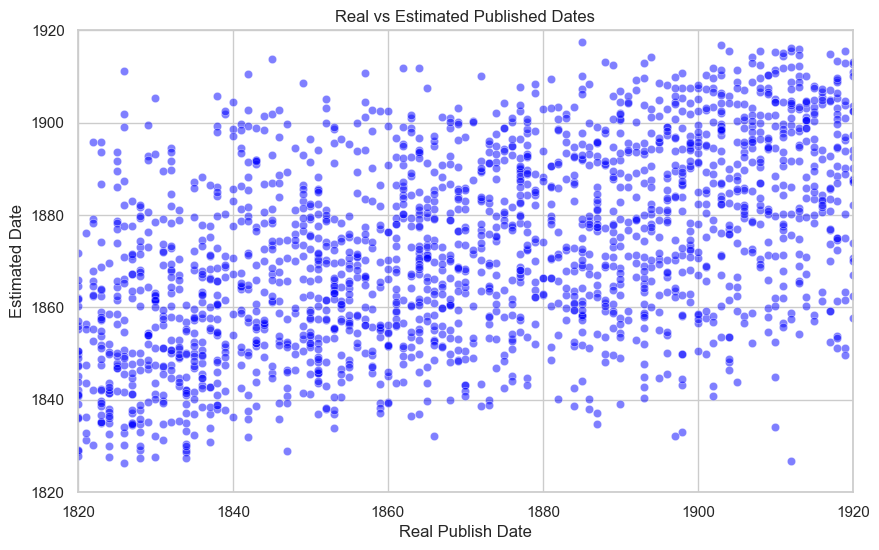

In [6]:
query_real_dates = df_test['date'].tolist()
predictions, raw_outputs = model.predict(df_test['text'].tolist())
prediction_dates = [get_date_from_prediction(pred) for pred in predictions]

print(f"Percentage of predictions within 10 years: {calculate_percentage_of_predictions_within_10_years(prediction_dates, query_real_dates)}")
print(f"Mean Absolute Error: {calculate_mean_absolute_error(prediction_dates, query_real_dates)}")
print(f"Standard Deviation: {calculate_stadard_deviation(prediction_dates)}")

rmse = np.sqrt(mean_squared_error(query_real_dates, prediction_dates))
print(f"RMSE: {rmse}")

r2 = r2_score(query_real_dates, prediction_dates)
print(f"R2: {r2}")

plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.scatterplot(x=query_real_dates, y=prediction_dates, color='blue', alpha=0.5)
plt.title('Real vs Estimated Published Dates')
plt.xlabel('Real Publish Date')
plt.xlim(earliest_date, latest_date)
plt.ylabel('Estimated Date')
plt.ylim(earliest_date, latest_date)
plt.grid(True)
plt.savefig('bert-results.png', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()